In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import magnetopy as mp

DATA_PATH = Path("../../tests/data/")

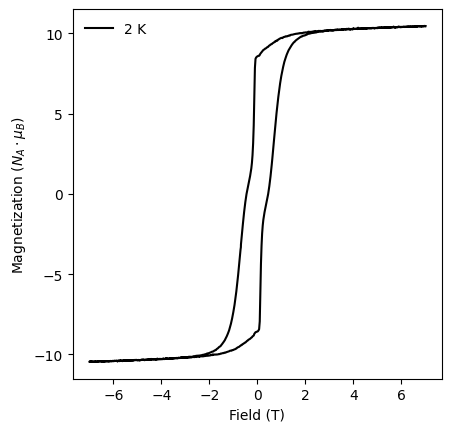

In [2]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")
mvsh = dset1.get_mvsh(2)
fig, ax = mvsh.plot()

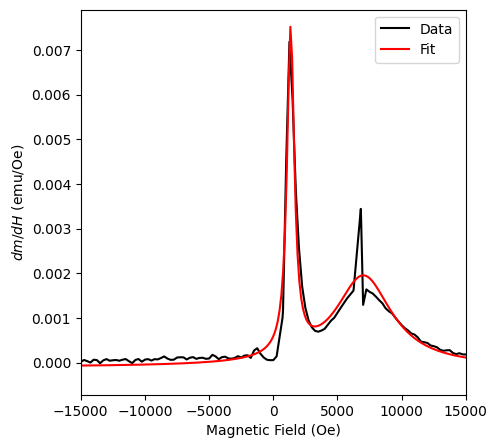

In [3]:
df = mvsh.simplified_data("forward").copy()
df['dmdh'] = np.gradient(df['moment'], df['field'])

results1 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], 2)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results1)

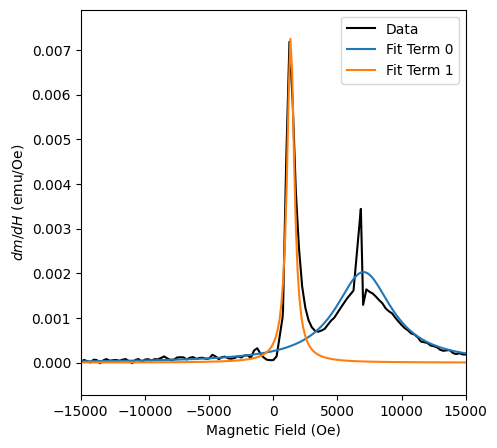

In [4]:
df = mvsh.simplified_data("forward").copy()
df['dmdh'] = np.gradient(df['moment'], df['field'])

results1 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], 2)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results1, False, True)

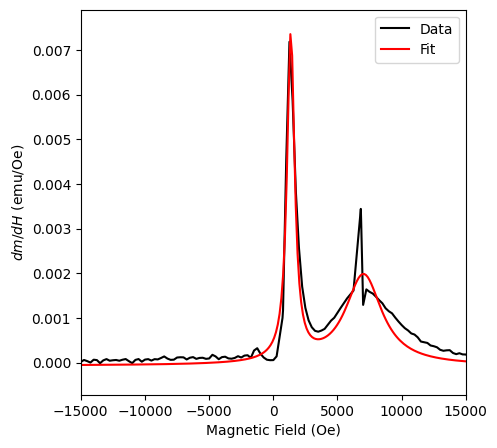

In [5]:
fitting_args = mp.CauchyFittingArgs(
    [
        mp.CauchyParams(5, 1000, 2000),
        mp.CauchyParams(8, 7000, 10000),
    ]
)
results2 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], fitting_args)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results2)

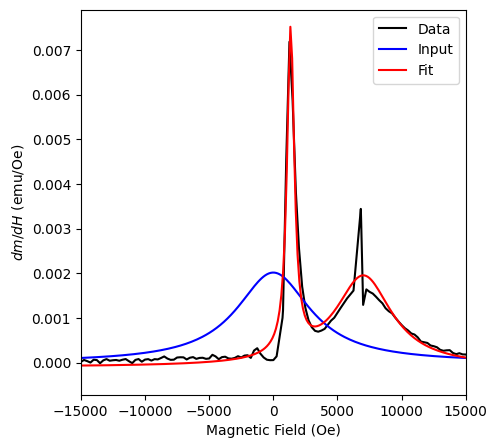

In [6]:
cauchy1 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "forward"), 2)
fig, ax = cauchy1.plot(input_params = True)

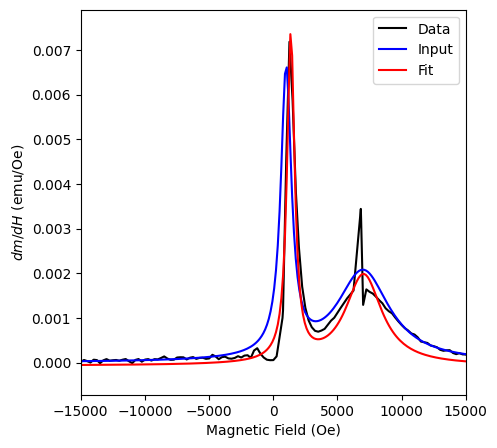

In [7]:
cauchy2 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "forward"), fitting_args)
fig, ax = cauchy2.plot(input_params = True)

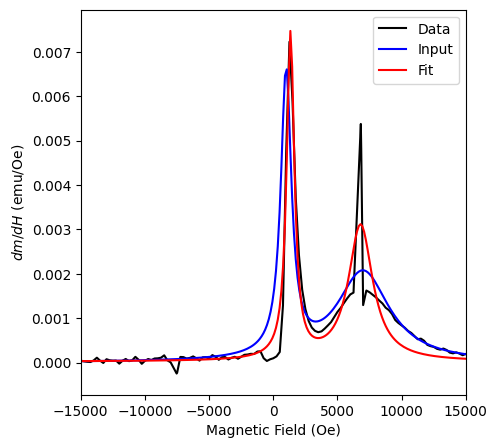

In [8]:
cauchy3 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "reverse"), fitting_args)
fig, ax = cauchy3.plot(input_params = True)

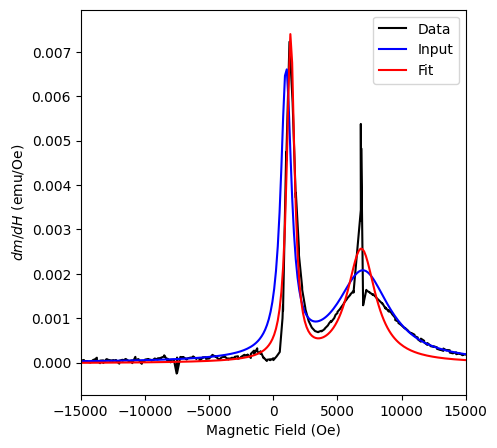

In [9]:
cauchy4 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2), fitting_args)
fig, ax = cauchy4.plot(input_params = True)

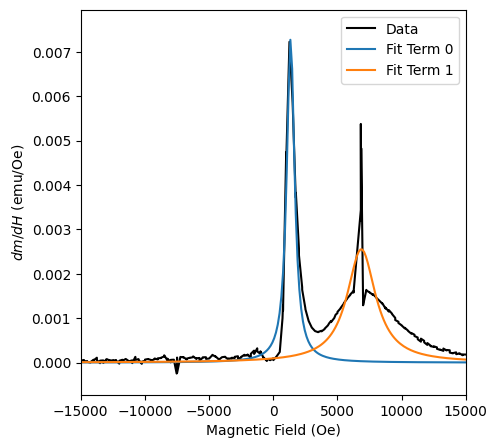

In [10]:
cauchy4 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2), fitting_args)
fig, ax = cauchy4.plot(False, True)